# Overview of Methods

For each ward:

1. Read in the centers for each image.
2. Adjust the centers down.
3. Extract two images of size 400x425 from each adjusted center. One plain image and one with ward ovelayed in pure black.
4. Write each image to the directory /images/ward_k/ij_with_ward.png where k is the ward number and ij are the row and column positions, respectively, of the image in the grid of images from the specific ward (e.g. top left = 00).
5. Use the image with the ward overlayed to isolate the pixels that are outside of the ward. Set those pixels to black in the image without the ward in order to isolate the section of the image that contains the ward.
6. Remove the Google watermarks (i.e. bottom 25 pixels).
7. Write the edited image to the directory /images/ward_k/edited/ij.png

# Libraries Used

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import os
import ast

# Constants

### Conversion of lat/lng to pixels

In order to sample without overlap from the grid of images within the ward, we need to obtain the length of the sampled images in the y- and the x-direction.

In [2]:
## Radius of squares in grid, figured out by mixture of observation and calculation
Y_RAD = 0.00385
X_RAD = 0.0043
N_WARDS = 130

In [3]:
BASE_DIR = '..'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
DATA_DIR = os.path.join(BASE_DIR, 'data')
SHAPE_DIR = os.path.join(BASE_DIR, 'shapefile')

### Adjustment to crop out watermarks

Although we need images of dimension 400x400, we are sampling images of size 400x425 (more pixels in the y-direction) and cropping the bottom 25px in order to remove the Google watermarks - resulting in a 400x400 image. However, to do this, we need to shift the center of our sampled images slighly lower, as we are removing pixels from only the bottom of the image, even though there are $\approx 12.5$ pixels at the top of the image that are also being added. Thus, we need to shift the center down "12.5 pixels". Converting this to lat/lng values, we get that:
$200$px $\approx 0.00385^{\circ}$. So it follows that $12.5$px $\approx 0.00385^{\circ}/16$

<img src="../images_for_demo/Grid_img_without_adjustment.PNG" width="300">
<img src="../images_for_demo/Grid_img_with_adjustment.PNG" width="300">

In [4]:
DELTA_Y = Y_RAD/16  # adjustment to crop out watermarks

In [5]:
# get the Google Static Maps API key
with open("../google_api_key.txt", "r") as file:
    KEY = file.readline()

# Extract Images for each Ward

In [6]:
# read in ward image centers
df_ward_centers = pd.read_csv(os.path.join(DATA_DIR, "ward_image_centers.csv")) 
print(df_ward_centers.dtypes)
df_ward_centers.head()

ward_no.        int64
img_centers    object
dtype: object


,ward_no.,img_centers
0,1,"[[(-26.483020238999927, 27.828767997000057), (..."
1,2,"[[(-26.496054001999937, 27.86212946200004), (-..."
2,3,"[[(-26.47171999699998, 27.85499519800004), (-2..."
3,4,"[[(-26.448650998999938, 27.84236260700004), (-..."
4,5,"[[(-26.424091998999927, 27.763540001000024), (..."


In [18]:
def download_img(center_str, path, col=1):
    if col == 1:
        request = "https://maps.googleapis.com/maps/api/staticmap?center={}&zoom=16&size=400x425&maptype=satellite&format=png&path=fillcolor:0x000000FF|color:0x000000FF|weight:1{}&key={}".format(center_str, path, KEY)
    elif col == 2:
        request = "https://maps.googleapis.com/maps/api/staticmap?center={}&zoom=16&size=400x425&maptype=satellite&format=png&path=fillcolor:0x00FF00FF|color:0x00FF00FF|weight:1{}&key={}".format(center_str, path, KEY)

    # HTTP requests
    return(requests.get(request)) 

In [19]:
def get_imgs(center_str, ward_num, pos, path):
    
    # extrecting two images for each center
    response_with_ward = download_img(center_str, path)           # image with ward overlayed in black
    response_with_ward_green = download_img(center_str, path, 2)     # image with ward overlayed in green
    response_no_ward = download_img(center_str, "")                  # plain image
    
    if not os.path.exists(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num))):
        os.makedirs(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num)))
    
    # storing the responses in a file (images)
    with open(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), str(pos[0]) + "_" + str(pos[1]) + "_with_ward.png"), 'wb') as file:
       # writing data into the file
       file.write(response_with_ward.content)
        
    with open(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), str(pos[0]) + "_" + str(pos[1]) + "_with_ward_green.png"), 'wb') as file:
       # writing data into the file
       file.write(response_with_ward_green.content)

    with open(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), str(pos[0]) + "_" + str(pos[1]) + ".png"), 'wb') as file:
       # writing data into the file
       file.write(response_no_ward.content)

In [20]:
# function for converting coordinates to format for Google Static Maps API
def center_to_string(center):
    return str(center[0]) + "," + str(center[1])

In [21]:
# Opening JSON file of ward shapes
def get_all_ward_shapes(file_name):
    f = open(file_name,) 
    shape_dict = json.load(f)                     # Returns JSON object as a dictionary 
    f.close()
    return shape_dict

In [22]:
## Extracting coordinates for first ward
def get_ward_shape(shape_dict, ward_num):
    coords = shape_dict['features'][ward_num]["geometry"]["coordinates"][0]
    return coords

In [23]:
## Constructing path for ward outline
def coords_to_path(coords):
    path = ""
    for lat, lng in coords:
        path = path + "|" + str(lng) + "," + str(lat)
    return path

In [24]:
# dictionary of coordinates for all the wards
shape_file_dict = get_all_ward_shapes(os.path.join(SHAPE_DIR, 'electoral wards for jhb (simple).json'))

In [25]:
# Checking Google Static Maps API path length retrictions. If this fails, look to 'simplify' the shapefile using mapshaper.
for ward_num in range(1, N_WARDS+1):
    for i, cols in enumerate(ast.literal_eval(df_ward_centers["img_centers"][ward_num-1])):
        coords = get_ward_shape(shape_file_dict, ward_num-1)
        path = coords_to_path(coords)
        assert len(path) < 8192, "path is too long: error for ward" + ward_num

In [ ]:
# Dowload images from Google Static Maps API for each ward
# Saved in file ./images/ward_i
# Two imgs from same location: 
## (row_col).png - plain img
## (row_col)_with_ward.png - img with ward overlayed
# (row,col) are matrix coordinates
# use ast.literal_eval: '[1,2]' -> [1,2]

for ward_num in range(1, N_WARDS + 1):
    print('Starting extraction for ward {}'.format(ward_num))
    for i, cols in enumerate(ast.literal_eval(df_ward_centers["img_centers"][ward_num-1])):
        coords = get_ward_shape(shape_file_dict, ward_num-1)
        path = coords_to_path(coords)
        assert len(path) < 8192, "path is too long: error for ward" + ward_num
        for j, row_center in enumerate(cols):
            center_shifted = (row_center[0] - DELTA_Y, row_center[1])              # shifting the center down by DELTA_Y
#             get_imgs(center_to_string(center_shifted), ward_num, (i,j), path)      # uncomment to download images
    print('Images for ward {} extracted'.format(ward_num))
    
    

In [480]:
arr1 = [(1,2),(3,4), (1,2)]
arr2 = [(1,2),(3,4),(5,6)]

set(arr1).intersection(set(arr2))

{(1, 2), (3, 4)}

In [ ]:
# Edit Plain Images to only Contain Ward Area and Save

In [488]:
# For saving the edited image to ./images/ward_i/edited
def save_edited_img(ward_num, f_no_ward, img, mask):
    
    # create directory if it doesn't exist
    if not os.path.exists(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'edited')):
        os.makedirs(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'edited'))
    if not os.path.exists(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'masks')):
        os.makedirs(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'masks'))
    
    # writing the image to directory
    cv2.imwrite(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'edited', f_no_ward), img)
    cv2.imwrite(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'masks', f_no_ward), mask)

In [499]:
def transform_to_arr(inds):
    x_list, y_list = inds
    inds_transformed = [(i,j) for i,j in zip(x_list, y_list)]
    return(inds_transformed)

In [500]:
def get_intersecting_points(inds1_transformed, inds2_transformed):
    
    inter = set(inds1_transformed).intersection(set(inds2_transformed))
    
#     longest_pix_list = (len(inds1_transformed), len(inds2_transformed)).index(max(len(inds1_transformed), len(inds2_transformed)))
#     inter = []
#     if longest_pix_list == 0:
#         inter = [(x1,y1) for (x1,y1) in inds1_transformed if (x1,y1) in inds2_transformed]
        
# #         for (x1,y1) in inds1_transformed:
# #             if (x1,y1) in inds2_transformed:
# #                 inter.append((x1,y1))
#     elif longest_pix_list == 1:
#         inter = [(x1,y1) for (x1,y1) in inds2_transformed if (x1,y1) in inds1_transformed]
        
#         for (x1,y1) in inds2_transformed:
#             if (x1,y1) in inds1_transformed:
#                 inter.append((x1,y1))
    return inter

In [501]:
def get_union_points(inds1_transformed, inds2_transformed):
    
    union = list(set().union(inds1_transformed, inds2_transformed))
    
#     union = [(x1,y1) for (x1,y1) in inds2_transformed if not (x1,y1) in inds1_transformed]
    
#     union.extend(inds1_transformed)
    
#     for (x1,y1) in inds1_transformed:
#         union.append((x1,y1))
#     for (x1,y1) in inds2_transformed:
#         if not (x1,y1) in union:
#             union.append((x1,y1))
    return union

In [502]:
def recreate_pix_object(inter):
    x_arr = []
    y_arr = []
    for xy in inter:
        x, y = xy
        x_arr.append(x)
        y_arr.append(y)
    return((np.array(x_arr).astype(int), np.array(y_arr).astype(int)))

In [503]:
def get_pix_in_ward(inds1, inds2):
    inds_transformed_1 = transform_to_arr(inds1)
    inds_transformed_2 = transform_to_arr(inds2)
    inter = get_intersecting_points(inds_transformed_1, inds_transformed_2)
    return recreate_pix_object(inter)
    

In [504]:
def get_pix_out_ward(inds1, inds2):
    inds_transformed_1 = transform_to_arr(inds1)
    inds_transformed_2 = transform_to_arr(inds2)
    union = get_union_points(inds_transformed_1, inds_transformed_2)
    return recreate_pix_object(union)

In [505]:
get_pix_out_ward(inds1, inds2)

(array([1, 3, 6, 5, 1]), array([2, 4, 1, 6, 6]))

In [508]:
# For setting the area of the img outside of the ward to black
# Edited image saved to ./images/ward_i/edited
def isolate_ward_in_img(ward_num, f_with_ward, f_with_ward_green, f_no_ward):
    
    img_with_ward = cv2.imread(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), f_with_ward))
    img_with_ward_green = cv2.imread(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), f_with_ward_green))
    img_no_ward = cv2.imread(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), f_no_ward))
    
    img_with_ward_cropped = img_with_ward[0:400,:,:]                  # cropping out the watermarks
    img_with_ward_green_cropped = img_with_ward_green[0:400,:,:]      # cropping out the watermarks
    img_no_ward_cropped = img_no_ward[0:400,:,:]                      # cropping out the watermarks
    
    # selecting all non-black pixels from image with ward overlayed (want to remove these from plain image)
    inds1 = np.where(np.all(img_with_ward_cropped == [0,0,0], axis=-1))
    inds2 = np.where(np.all(img_with_ward_green_cropped == [0,254,0], axis=-1))
    
    inds1_not = np.where(~np.all(img_with_ward_cropped == [0,0,0], axis=-1))
    inds2_not = np.where(~np.all(img_with_ward_green_cropped == [0,254,0], axis=-1))
    
    pix_in_ward = get_pix_in_ward(inds1, inds2)
    pix_out_ward = get_pix_out_ward(inds1_not, inds2_not)
    
#     pix_in_ward = np.where(np.all(img_with_ward_green_cropped == [0,254,0], axis=-1))
#     pix_out_ward = np.where(np.all(img_with_ward_green_cropped != [0,254,0], axis=-1))
# #     pix_out_ward = np.where(np.all(img_with_ward_green_cropped != [0,254,0], axis=-1))

    if len(pix_in_ward[0]) == 0 and len(pix_in_ward[1]) == 0:
        print("Ward {}: no ward in image {}, not saving.".format(ward_num, f_no_ward))
        return 0, 0
    
    img_with_ward_cropped[pix_in_ward] = [255,255,255]  # setting pixels out ward to pure white for the mask
    img_with_ward_cropped[pix_out_ward] = [0,0,0]  # setting pixels out ward to pure white for the mask
    
    # setting all non-black pixels from image without ward overlayed to black in plain image
#     img_no_ward_cropped[pix_out_ward] = [0,0,0]
    return img_no_ward_cropped, img_with_ward_cropped

In [511]:
# looping through the directories for each ward and editing the images, then saving
# the results will be two directories ./images/ward_i/edited and ./images/ward_i/masks
# which contain the editted plain images and masks for each image, respectively.
for ward_num in range(1, N_WARDS+1):
    directory = os.fsencode(os.path.join(IMAGE_DIR, "ward_" + str(ward_num)))
    i = 0
    j = 0
    f_with_ward = f_no_ward = f_with_ward_green = ''
    file_name = os.fsencode("{}_{}.png".format(i,j)) 
    files_in_dir = os.listdir(directory)
    while file_name in files_in_dir:
        while(file_name in files_in_dir):
            f_no_ward = os.fsdecode(file_name)
            f_with_ward = "{}_{}_with_ward.png".format(i,j)
            f_with_ward_green = "{}_{}_with_ward_green.png".format(i,j)
            img_plain_cropped, mask = isolate_ward_in_img(ward_num, f_with_ward, f_with_ward_green, f_no_ward)  # cropping and editing image
            if type(img_plain_cropped) != int and type(mask) != int:
                save_edited_img(ward_num, f_no_ward, img_plain_cropped, mask)                    # saving edited image

            j += 1
            file_name = os.fsencode("{}_{}.png".format(i,j)) 
        j = 0
        i += 1
        file_name = os.fsencode("{}_{}.png".format(i,j)) 


Ward 1: no ward in image 0_5.png, not saving.
Ward 1: no ward in image 2_1.png, not saving.
Ward 1: no ward in image 3_1.png, not saving.
Ward 1: no ward in image 3_2.png, not saving.
Ward 1: no ward in image 3_5.png, not saving.
Ward 2: no ward in image 3_0.png, not saving.
Ward 3: no ward in image 0_3.png, not saving.
Ward 3: no ward in image 3_0.png, not saving.
Ward 3: no ward in image 3_1.png, not saving.
Ward 5: no ward in image 0_0.png, not saving.
Ward 5: no ward in image 0_1.png, not saving.
Ward 5: no ward in image 0_2.png, not saving.
Ward 5: no ward in image 0_9.png, not saving.
Ward 5: no ward in image 0_10.png, not saving.
Ward 5: no ward in image 0_11.png, not saving.
Ward 5: no ward in image 1_0.png, not saving.
Ward 5: no ward in image 1_1.png, not saving.
Ward 5: no ward in image 1_2.png, not saving.
Ward 5: no ward in image 1_9.png, not saving.
Ward 5: no ward in image 1_10.png, not saving.
Ward 5: no ward in image 1_11.png, not saving.
Ward 5: no ward in image 2_0.p

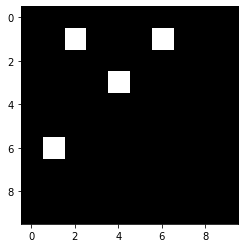

In [434]:
im[1,2,:] = [255,255,255]
im[3,4,:] = [255,255,255]
im[1,6,:] = [255,255,255]
im[6,1,:] = [255,255,255]
plt.imshow(im)

In [8]:
def plot_fig(img):
    img_matplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_matplot)